In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random

In [2]:
market=pd.read_excel('Prueba.xlsx', index_col=0)

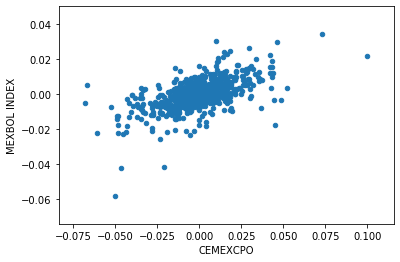

In [3]:
rets=market.pct_change().dropna(axis=0)
rets.columns=[col.replace(" MF Equity","") for col in rets.columns]
rets.plot.scatter(x="CEMEXCPO", y="MEXBOL INDEX")

In [4]:
N=len(rets)
N

672

In [5]:
I=np.concatenate([np.identity(2)]*2,axis=1)
I=np.concatenate([I]*2,axis=0)
I

array([[1., 0., 1., 0.],
       [0., 1., 0., 1.],
       [1., 0., 1., 0.],
       [0., 1., 0., 1.]])

In [6]:
Phi=rets.iloc[:,:-1].values
t=rets.iloc[:,[-1]]
N,M=Phi.shape

I=np.concatenate([np.identity(M)]*2,axis=1)
I=np.concatenate([I]*2,axis=0)

I.shape

(70, 70)

In [7]:
P=np.ones((N,M))
P=np.c_[P,Phi]

In [8]:
W=np.linalg.inv((P.T @ P)* I)@ P.T @ t
W["security"]=np.concatenate([rets.columns[:-1]]*2)
W["param"]=["alpha"]*M+["beta"]*M
B=W.pivot_table(index="security", columns="param", values="MEXBOL INDEX")

In [9]:
from ipywidgets import interact

@interact(security=rets.columns[:-1])
def plot_cmap(security):
    rets.plot.scatter(x=security, y="MEXBOL INDEX")
    sec=rets[security]
    x=np.linspace(sec.min(),sec.max(),100)
    alpha, beta= B.loc[security]
    #plt.title(rf"$\alpha={alpha:o.3f}$ | $\beta={beta:0.3f}$")
    plt.plot(x, alpha +beta*x, c="tab:orange", linewidth=4)

interactive(children=(Dropdown(description='security', options=('KIMBERA', 'GAPB', 'CEMEXCPO', 'ASURB', 'GFNOR…

In [10]:
Datos=pd.read_excel('PreciosPortf.xlsx',index_col=0)

In [11]:
rend=Datos.pct_change().dropna()
rend_ports=rend.mean()*252

In [12]:
rend_ports

ASURB MF Equity       0.123539
GFNORTEO MF Equity    0.078811
PE&OLES* MF Equity    0.111053
WALMEX* MF Equity     0.082426
IENOVA* MF Equity     0.078997
dtype: float64

In [13]:
rend.cov()

,ASURB MF Equity,GFNORTEO MF Equity,PE&OLES* MF Equity,WALMEX* MF Equity,IENOVA* MF Equity
ASURB MF Equity,0.000224,0.000086,0.000061,0.000036,0.000044
GFNORTEO MF Equity,0.000086,0.000341,0.000094,0.000082,0.000082
PE&OLES* MF Equity,0.000061,0.000094,0.000548,0.000041,0.000045
WALMEX* MF Equity,0.000036,0.000082,0.000041,0.000215,0.000043
IENOVA* MF Equity,0.000044,0.000082,0.000045,0.000043,0.000226


In [15]:
random.seed(314)
w = np.random.random(size=5)
w = w / w.sum()

In [16]:
(rend.mean()@w).sum()*252

0.10319419743261868

In [17]:
E_p=(rend.mean()@w)*252
S_p=np.sqrt(w.T@(rend.cov()*252)@w)
V_p=rend.resample('Y').last().pct_change().var(ddof=0)@w

def port_rend(w,r):
    E_p=(r.mean()@w)*252
    return E_p

def port_vol(w,r):
    s_p=np.sqrt(w.T@(rend.cov()*252)@w)
    return s_p

def port_var(w,r):
    v_p=r.resample('Y').last().pct_change().var(ddof=0)@w
    return v_p


In [18]:
weights_sim = np.random.random((5000,5))
weights_sim=weights_sim/weights_sim.sum(axis=1, keepdims=True)

rend_sim= np.apply_along_axis(port_rend, 1, weights_sim, r=rend)
vol_sim= np.apply_along_axis(port_vol, 1, weights_sim, r=rend)

Text(0, 0.5, 'E(r)')

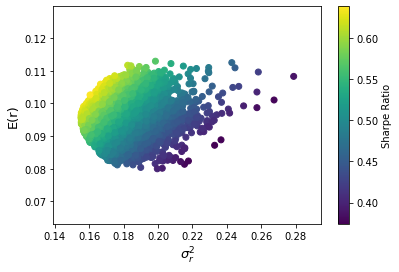

In [19]:
sharpe_ratio = rend_sim / vol_sim
plt.scatter(vol_sim, rend_sim, c=sharpe_ratio)
plt.colorbar(label="Sharpe Ratio")
plt.xlabel(r"$\sigma^2_r$", fontsize=13)
plt.ylabel("E(r)", fontsize=13)

# Frontera ef

In [20]:
from scipy.optimize import minimize

In [21]:
N, M  = rend.shape
w0 = np.random.randn(M)

def sum_weights(weights):
    return weights.sum() -1

constraints = [
    {"type":"eq", "fun":sum_weights}
]
port0 = minimize(port_vol, w0, constraints=constraints, args=rend)
port0

     fun: 0.1551619951487309
     jac: array([0.15509058, 0.15529835, 0.15484772, 0.15522091, 0.15524883])
 message: 'Optimization terminated successfully.'
    nfev: 78
     nit: 11
    njev: 11
  status: 0
 success: True
       x: array([0.28154507, 0.04453366, 0.08945461, 0.30813989, 0.27632677])

In [22]:
wp0 = port0.x
port_rend(wp0,rend),port_vol(wp0,rend)

(0.09545353346356211, 0.1551619951487309)

# Opti

In [23]:
N, M  = rend.shape
w0 = np.random.randn(M)

def sum_weights(weights):
    return weights.sum() -1 # == 0

def rend_esperado(w, E):
    return port_rend(w, rend) - E # == 0

def var_esperada(w, E):
    return port_var(w, rend) - E # == 0

e0 = .1
e1 =100
constraints = [
    {"type":"eq", "fun":sum_weights},
    {"type":"eq", "fun":lambda w: rend_esperado(w, e0)},
    #{"type":"ineq", "fun":lambda w: rend_esperado(w, e0)}
    
]
port1 = minimize(port_vol, w0, constraints=constraints, args=rend)
port1

     fun: 0.1571517716101341
     jac: array([0.17773362, 0.13864405, 0.16673482, 0.14201015, 0.13855514])
 message: 'Optimization terminated successfully.'
    nfev: 71
     nit: 10
    njev: 10
  status: 0
 success: True
       x: array([0.37282401, 0.00681411, 0.10726068, 0.27981883, 0.23328237])

In [24]:
wp1 = port1.x
port_rend(wp1,rend),port_vol(wp1,rend)

(0.0999999999973142, 0.1571517716101341)

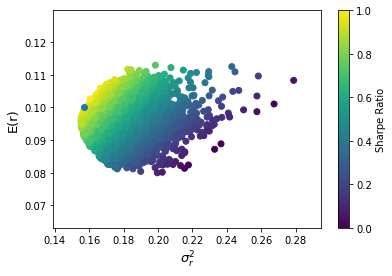

In [25]:
sharpe_ratio = rend_sim / vol_sim
plt.scatter(vol_sim, rend_sim, c = sharpe_ratio)
plt.scatter(port_vol(wp1,rend),port_rend(wp1,rend))
plt.colorbar(label="Sharpe Ratio")
plt.xlabel(r"$\sigma^2_r$", fontsize=13)
plt.ylabel("E(r)",fontsize=13);

In [26]:
rmin = rend_ports.min()
rmax = rend_ports.max()
rend_max = np.linspace(rmin,rmax)

In [27]:
pesos_optimos = []
for e in rend_max:
    constraints = [
        {"type":"eq", "fun":sum_weights},
        {"type":"eq", "fun":lambda w: rend_esperado(w, e)}
    ]
    port1 = minimize(port_vol, w0, constraints=constraints, args=rend)
    w_opt = port1.x
    pesos_optimos.append(w_opt)

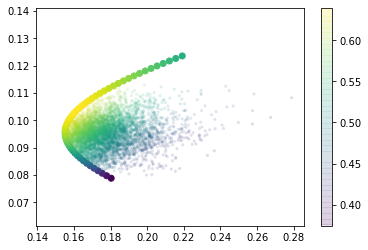

In [28]:
r_opt = []
v_opt = []
for w in pesos_optimos:
    r_opt.append(port_rend(w,rend))
    v_opt.append(port_vol(w,rend))
r_opt = np.array(r_opt)
v_opt = np.array(v_opt)

plt.scatter(v_opt,r_opt, c=r_opt/v_opt)
plt.scatter(vol_sim,rend_sim, c=sharpe_ratio, alpha = 0.1, s=5)
plt.colorbar()

# Prtafolio Tangencial

In [29]:
rf = 0.06
def min_func_sharpe(weights):
        return - (port_rend(weights, rend) - rf)/ port_vol(weights,rend)

constraints = [
    {"type":"eq", "fun":sum_weights}
]
f_sharpe = minimize(min_func_sharpe,w0, constraints=constraints)

In [30]:
w_sharpe = f_sharpe.x

In [31]:
e_sharpe = port_rend(w_sharpe, rend)
vol_sharpe = port_vol(w_sharpe, rend)

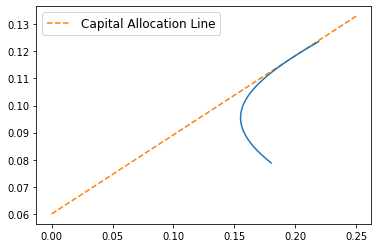

In [32]:
sigma_c = np.linspace(0,0.25)
sharpe = rf + sigma_c*(e_sharpe - rf)/vol_sharpe
plt.plot(sigma_c, sharpe, linestyle="--",c="tab:orange", label="Capital Allocation Line")
plt.plot(v_opt, r_opt)
plt.plot()
plt.legend(fontsize=12)

In [33]:
e0 = .1
e1 =1000
constraints = [
    {"type":"eq", "fun":sum_weights},
    {"type":"eq", "fun":lambda w: rend_esperado(w, e0)},
    {"type":"ineq", "fun":lambda w: rend_esperado(w, e1)}
    
]
port2 = minimize(port_vol, w0, constraints=constraints, args=rend)
port2

     fun: 58774.63747436975
     jac: array([-0.00683594, -0.06738281, -0.12451172,  0.15332031, -0.11328125])
 message: 'Iteration limit exceeded'
    nfev: 1351
     nit: 101
    njev: 98
  status: 9
 success: False
       x: array([  19500.35522742,  -58206.57505533,  -50930.97366164,
        220845.50298458, -131206.43983316])

In [34]:
wp2 = port2.x
port_rend(wp2,rend),port_vol(wp2,rend)

(4.115413524656105, 58774.63747436975)

In [35]:
pesos_optimos2 = []
for e in rend_max:
    constraints = [
        {"type":"eq", "fun":sum_weights},
        {"type":"eq", "fun":lambda w: rend_esperado(w, e)},
        {"type":"eq", "fun":lambda w: var_esperada(w, e)}
    ]
    port2 = minimize(port_vol, w0, constraints=constraints, args=rend)
    w_opt2 = port2.x
    pesos_optimos2.append(w_opt2)

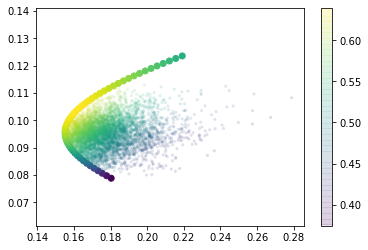

In [36]:
r_opt2 = []
v_opt2 = []
for w in pesos_optimos2:
    r_opt2.append(port_rend(w,rend))
    v_opt2.append(port_vol(w,rend))
r_opt2 = np.array(r_opt2)
v_opt2 = np.array(v_opt2)

plt.scatter(v_opt,r_opt, c=r_opt/v_opt)
plt.scatter(vol_sim,rend_sim, c=sharpe_ratio, alpha = 0.1, s=5)
plt.colorbar()

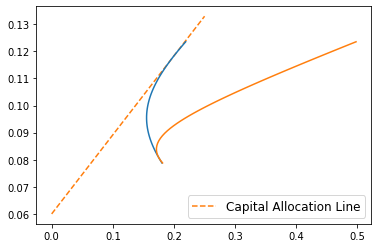

In [37]:
sigma_c = np.linspace(0,0.25)
sharpe = rf + sigma_c*(e_sharpe - rf)/vol_sharpe
plt.plot(sigma_c, sharpe, linestyle="--",c="tab:orange", label="Capital Allocation Line")
plt.plot(v_opt, r_opt)
plt.plot(v_opt2, r_opt2)
plt.plot()
plt.legend(fontsize=12)